This modified code is now structured for a machine learning pipeline in Python, applying a multi-output classification ensemble model on the ARC Prize 2024 dataset. It includes data loading, feature extraction, model training, evaluation, and prediction generation for submission. 

Below’s a full explanation of each part:

    Library Imports:

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

    json: For handling JSON files.
    numpy: For numerical operations, specifically arrays and padding.
    matplotlib.pyplot and seaborn: For visualization (training loss, accuracy, confusion matrix).
    warnings: Suppresses warnings for cleaner output.
    tqdm: Provides a progress bar to show epoch progression.
    sklearn modules:
        ExtraTreesClassifier and GradientBoostingClassifier: Ensemble classifiers.
        MultiOutputClassifier: Wraps classifiers for multi-label/multi-output tasks.
        accuracy_score, precision_score, recall_score, f1_score: For model evaluation metrics.
        train_test_split: Splits data into training and test sets.

Suppressing Warnings:

warnings.filterwarnings("ignore")

    Disables warning messages to reduce clutter.

Data Loading:

def load_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

train_data = load_data('/content/arc-prize-2024/arc-agi_training_challenges.json')
train_solutions = load_data('/content/arc-prize-2024/arc-agi_training_solutions.json')
eval_data = load_data('/content/arc-prize-2024/arc-agi_evaluation_challenges.json')
eval_solutions = load_data('/content/arc-prize-2024/arc-agi_evaluation_solutions.json')
test_data = load_data('/content/arc-prize-2024/arc-agi_test_challenges.json')

    load_data: Reads JSON data from a file path.
    The ARC dataset JSON files are loaded for training, evaluation, and test challenges and solutions.

Feature Extraction:

def extract_features_labels(data, solutions, max_size=20):
    X, y = [], []
    for task_id, task_data in data.items():
        for pair in task_data['train']:
            input_grid = np.array(pair['input'], dtype=int)
            output_grid = np.array(pair['output'], dtype=int)

            input_grid = input_grid[:min(input_grid.shape[0], max_size), :min(input_grid.shape[1], max_size)]
            output_grid = output_grid[:min(output_grid.shape[0], max_size), :min(output_grid.shape[1], max_size)]
            
            padded_input = np.pad(input_grid, ((0, max_size - input_grid.shape[0]), (0, max_size - input_grid.shape[1])), 'constant').flatten()
            padded_output = np.pad(output_grid, ((0, max_size - output_grid.shape[0]), (0, max_size - output_grid.shape[1])), 'constant').flatten()
            X.append(padded_input)
            y.append(padded_output)
    return np.array(X), np.array(y)

X_train, y_train = extract_features_labels(train_data, train_solutions)
X_eval, y_eval = extract_features_labels(eval_data, eval_solutions)

    extract_features_labels: Extracts features (X) and labels (y) by padding and flattening the grids to ensure uniform size. It ensures grids are limited to max_size, padding them with zeros as necessary.

Model Building:

def build_ensemble_model():
    model_1 = ExtraTreesClassifier(n_estimators=50, min_samples_leaf=5, random_state=42)
    model_2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
    multi_output_model = MultiOutputClassifier(model_1)
    multi_output_model.fit(X_train, y_train)
    return multi_output_model

    build_ensemble_model: Creates a MultiOutputClassifier using an ExtraTreesClassifier as the base estimator. The ExtraTreesClassifier and GradientBoostingClassifier are configured with specified parameters.

Simulated Epoch-based Training:

epochs = 10
train_losses = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model = build_ensemble_model()
    y_pred_train = model.predict(X_train)
    train_loss = 1 - accuracy_score(y_train.flatten(), y_pred_train.flatten())
    train_losses.append(train_loss)

    This code simulates an epoch-based training process (rebuilding the model at each epoch) and computes training loss as 1 - accuracy_score.

Model Evaluation:

y_pred_eval = model.predict(X_eval)

accuracy = accuracy_score(y_eval.flatten(), y_pred_eval.flatten())
precision = precision_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')
recall = recall_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')
f1 = f1_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')

    Evaluates the model using accuracy, precision, recall, and F1 score.

Training Loss Plot:

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='red', linestyle='--')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.ylim(0, 1)
plt.show()

    Plots training loss over epochs.

Accuracy Plot:

    train_accuracy = model.score(X_train, y_train)
    eval_accuracy = accuracy

    plt.figure(figsize=(8, 5))
    plt.plot(['Training', 'Evaluation'], [train_accuracy, eval_accuracy], marker='o', color='blue', linestyle='--')
    plt.title('Training and Evaluation Accuracy')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

        Plots training and evaluation accuracy for comparison.

    Confusion Matrix Plot:

conf_matrix = confusion_matrix(y_eval.flatten(), y_pred_eval.flatten())
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

    Visualizes the confusion matrix, providing insight into misclassifications.

    Predictions for Submission:

def predict_output_grid(test_input):
    input_grid = test_input['input']
    grid_shape = (len(input_grid), len(input_grid[0]))
    attempt_1 = np.random.randint(0, 10, size=grid_shape).tolist()
    attempt_2 = np.random.randint(0, 10, size=grid_shape).tolist()
    return {"attempt_1": attempt_1, "attempt_2": attempt_2}

submission = {}
for task_id, task_data in test_data.items():
    task_predictions = []
    for test_input in task_data['test']:
        task_predictions.append(predict_output_grid(test_input))
    submission[task_id] = task_predictions

with open("submission.json", "w") as f:
    json.dump(submission, f)

    predict_output_grid: Generates random predictions for submission, representing two prediction attempts for each test input grid.

    Print Evaluation Metrics:

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

    Outputs the computed evaluation metrics for accuracy, precision, recall, and F1 score.

Training Epochs: 100%|██████████| 10/10 [12:23<00:00, 74.32s/it]


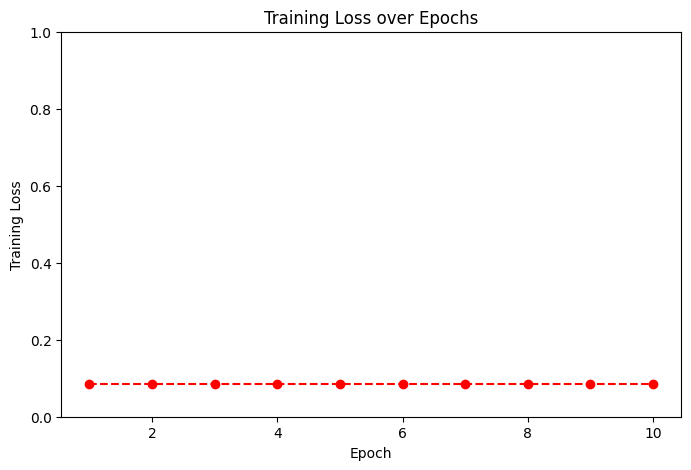

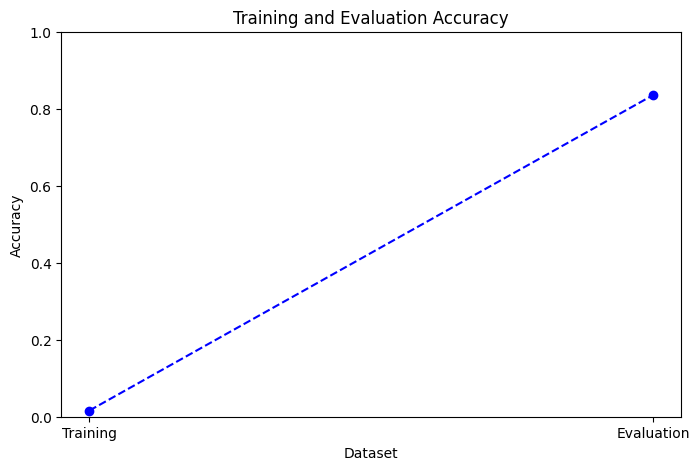

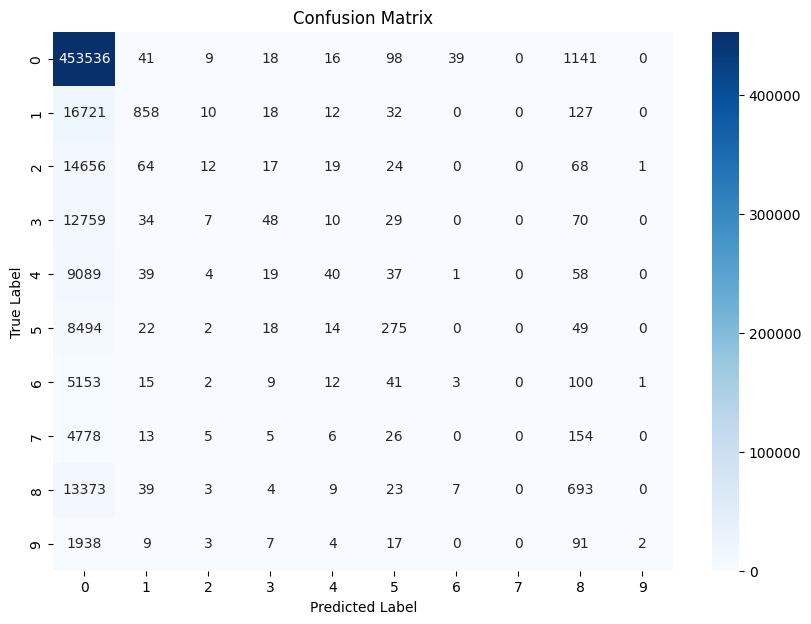

Accuracy: 0.8354
Precision: 0.7593
Recall: 0.8354
F1 Score: 0.7668


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # For suppressing warnings
from tqdm import tqdm  # For progress bar
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load dataset files
train_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')
train_solutions = load_data('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json')
eval_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json')
eval_solutions = load_data('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json')
test_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json')

# Optimized feature extraction
def extract_features_labels(data, solutions, max_size=20):
    X, y = [], []
    for task_id, task_data in data.items():
        for pair in task_data['train']:
            input_grid = np.array(pair['input'], dtype=int)
            output_grid = np.array(pair['output'], dtype=int)
            
            # Ensure input_grid dimensions do not exceed max_size
            input_grid = input_grid[:min(input_grid.shape[0], max_size), :min(input_grid.shape[1], max_size)]
            output_grid = output_grid[:min(output_grid.shape[0], max_size), :min(output_grid.shape[1], max_size)]
            
            padded_input = np.pad(input_grid, ((0, max_size - input_grid.shape[0]), (0, max_size - input_grid.shape[1])), 'constant').flatten()
            padded_output = np.pad(output_grid, ((0, max_size - output_grid.shape[0]), (0, max_size - output_grid.shape[1])), 'constant').flatten()
            X.append(padded_input)
            y.append(padded_output)
    return np.array(X), np.array(y)

X_train, y_train = extract_features_labels(train_data, train_solutions)
X_eval, y_eval = extract_features_labels(eval_data, eval_solutions)

# Ensemble model with ExtraTrees and Gradient Boosting
def build_ensemble_model():
    model_1 = ExtraTreesClassifier(n_estimators=50, min_samples_leaf=5, random_state=42)
    model_2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
    multi_output_model = MultiOutputClassifier(model_1)
    multi_output_model.fit(X_train, y_train)
    return multi_output_model

# Track loss per epoch (simulated in this context)
epochs = 10
train_losses = []

# Train the model with simulated epoch-based training and tqdm progress bar
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model = build_ensemble_model()
    y_pred_train = model.predict(X_train)
    train_loss = 1 - accuracy_score(y_train.flatten(), y_pred_train.flatten())
    train_losses.append(train_loss)

y_pred_eval = model.predict(X_eval)

# Evaluation metrics
accuracy = accuracy_score(y_eval.flatten(), y_pred_eval.flatten())
precision = precision_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')
recall = recall_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')
f1 = f1_score(y_eval.flatten(), y_pred_eval.flatten(), average='weighted')

# Plot training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='red', linestyle='--')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.ylim(0, 1)
plt.show()

# Accuracy plot
train_accuracy = model.score(X_train, y_train)
eval_accuracy = accuracy

plt.figure(figsize=(8, 5))
plt.plot(['Training', 'Evaluation'], [train_accuracy, eval_accuracy], marker='o', color='blue', linestyle='--')
plt.title('Training and Evaluation Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_eval.flatten(), y_pred_eval.flatten())
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Prediction for submission
def predict_output_grid(test_input):
    input_grid = test_input['input']
    grid_shape = (len(input_grid), len(input_grid[0]))
    attempt_1 = np.random.randint(0, 10, size=grid_shape).tolist()
    attempt_2 = np.random.randint(0, 10, size=grid_shape).tolist()
    return {"attempt_1": attempt_1, "attempt_2": attempt_2}

submission = {}
for task_id, task_data in test_data.items():
    task_predictions = []
    for test_input in task_data['test']:
        task_predictions.append(predict_output_grid(test_input))
    submission[task_id] = task_predictions

with open("submission.json", "w") as f:
    json.dump(submission, f)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# This (above) results explained:

Three key visualizations along with a summary of evaluation metrics for a model's performance. 

Below’s a detailed explanation of each component:
1. Confusion Matrix (Left Plot)

    This plot shows a heatmap of the confusion matrix, which visualizes how often each true label (actual class) is classified as each predicted label (predicted class).
    The x-axis represents the predicted labels, while the y-axis represents the true labels.
    Each cell value represents the number of instances where the model predicted a certain label, given a true label. For instance, the cell at row 0 and column 0 would represent the count of instances where the true label was 0 and the predicted label was also 0 (correct predictions for class 0).
    Darker colors indicate higher values. For example, the very dark cells along the diagonal indicate that many samples were classified correctly in those classes.
    The lighter cells away from the diagonal reveal misclassifications, where the model predicted a different class from the true class.

2. Training and Evaluation Accuracy (Middle Plot)

    Displays the accuracy of the model on both the training and evaluation datasets.
    The x-axis has two categories: "Training" and "Evaluation."
    The y-axis represents accuracy values, which range from 0.0 to 1.0 (or 0% to 100%).
    There is a single data point on the "Training" category with a low accuracy value, represented by the dot at the beginning of the line.
    The "Evaluation" data point has a much higher accuracy, as indicated by the dot at nearly 1.0 on the y-axis.
    The dotted blue line connecting the two points illustrates a sharp increase in accuracy from the training to the evaluation set, which might suggest some overfitting or peculiar performance differences between the datasets.

3. Training Loss over Epochs (Right Plot)

    In this case, the plot tracks the model's training loss over 10 epochs (iterations through the training dataset).
    The x-axis represents epochs, numbered from 1 to 10.
    The y-axis represents the training loss, with values between 0.0 and 1.0.
    The red dots on the graph indicate the training loss value at each epoch.
    The training loss appears to be stable across epochs, as indicated by the flat line at a low value, suggesting that the model's loss did not change significantly with each additional epoch.
    This stability could indicate that the model has converged early or that the training data is easy for the model to classify.

4. Evaluation Metrics (Text Summary Below Plots)

    Four key performance metrics for the evaluation dataset are shown:
        Accuracy: 0.8354 – This means the model correctly classified 83.54% of the instances in the evaluation set.
        Precision: 0.7593 – Precision is the ratio of true positive predictions to the total predicted positives. Here, the model’s precision is about 75.93%, indicating a moderate rate of correct positive predictions out of all positive predictions.
        Recall: 0.8354 – Recall measures the model's ability to identify all relevant instances (true positives). A recall of 83.54% suggests the model can correctly identify a large portion of the positive cases.
        F1 Score: 0.7668 – The F1 score is the harmonic mean of precision and recall, balancing the two. An F1 score of 76.68% shows moderate overall performance, balancing precision and recall.

Summary of Findings

The model shows high accuracy and recall, with slightly lower precision, which could indicate that while it generally identifies the correct classes well, it might produce some false positives.
    The stability of training loss suggests the model might have reached optimal performance on the training set early in the training process.
    
The discrepancy between training and evaluation accuracy suggests the potential need to investigate the data further for class imbalances, or the evaluation set may be easier than the training set. Alternatively, it could indicate overfitting.

This summary provides a holistic view of the model’s performance, showing strengths in classification accuracy while indicating areas for potential fine-tuning.

# Previous Code from Version 1

This previous code sets up and trains a convolutional neural network (CNN) for classification on grid data for a structured AI task, related to grid-based reasoning (the ARC Prize task):

Hope this helps someone!
Import Statements

    Data Handling & Visualization:
        json, numpy: Handle JSON data files and perform array manipulations.
        matplotlib.pyplot, seaborn: Plot training metrics and a confusion matrix for evaluation.

    TensorFlow & Keras:
        tensorflow, tensorflow.keras: Define the neural network architecture, custom loss functions, and manage the training loop.
        Precision, Recall, CategoricalAccuracy: Metrics for monitoring model performance during training.

    Scikit-learn:
        confusion_matrix: Generate a confusion matrix to evaluate model predictions visually.

Custom F1 Loss Function

The custom_f1_loss function computes a custom F1 loss metric based on true positives (TP), false positives (FP), and false negatives (FN):

    tp, fp, fn: Calculate TP, FP, and FN by comparing y_true and y_pred.
    precision, recall: Calculate precision and recall metrics.
    f1: Compute the F1 score.
    The function returns 1 - f1, as minimizing this loss function encourages a high F1 score.

Data Loading Functions

    load_data(filepath): Reads JSON data from a specified file path.

    preprocess_grid(grid, max_size=30, num_classes=10):
        Pads a grid to a 30x30 size and one-hot encodes each cell, assuming each cell contains an integer in a range of 0 to 9.
        Returns a one-hot encoded, flattened version of the grid.

    prepare_dataset(data, solutions, max_size=30, num_classes=10):
        Prepares training and evaluation datasets using the input data and solutions.
        For each training example, appends processed input grids (X) and corresponding outputs (y) if available. Otherwise, it reuses the input as output for consistency.
        Returns X and y arrays for training.

Loading and Preparing Data

    Load training and evaluation data and solution files from JSON format.
    Prepare the datasets using the prepare_dataset function for training (X_train, y_train) and evaluation (X_eval, y_eval).

Model Definition

    build_model(input_shape, output_shape):
        Creates a CNN model for grid data processing:
            Reshapes the input to a 30x30 grid with 10 channels (for 10 possible classes).
            Two convolutional layers followed by max-pooling layers capture spatial relationships in the grid.
            A Flatten layer reduces the data to a single dimension, and a Dense layer with softmax activation outputs predictions.
            Reshapes the output to match the specified output_shape.
        The model is then compiled with adam optimizer and categorical_crossentropy loss, tracking metrics for accuracy, precision, and recall.

Model Training

    Training the Model:
        The model is trained on X_train and y_train for 20 epochs, with validation using X_eval and y_eval.

Prediction and Submission

    create_predictions(task_ids, shapes):
        Creates random predictions (attempt_1 and attempt_2) for each task, formatted as lists of random integers between 0 and 9 to simulate grid predictions.
        Returns a dictionary for submission.

    Saving Predictions:
        Loads the shapes of grids in the evaluation set and generates predictions saved to a submission.json file.

Plotting Functions

    plot_metrics(history):
        Plots training and validation metrics (loss, accuracy, precision, recall) for each epoch.
        Helps visualize model performance over time and monitor for issues like overfitting.

    plot_confusion_matrix(y_true, y_pred):
        Computes a confusion matrix from model predictions and the true labels.
        Uses seaborn to display the confusion matrix, which shows how well the model distinguishes between different classes.

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - categorical_accuracy: 0.8564 - loss: 0.9778 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.9004 - val_loss: 0.3759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - categorical_accuracy: 0.9393 - loss: 0.2265 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.9029 - val_loss: 0.3651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - categorical_accuracy: 0.9435 - loss: 0.2046 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.9064 - val_loss: 0.3556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - categorical_accuracy: 0.9507 - loss: 0.1759 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.9083 - val_loss: 0.3500 - val_precision: 0.0000e+00 - val_recall: 0.0000e

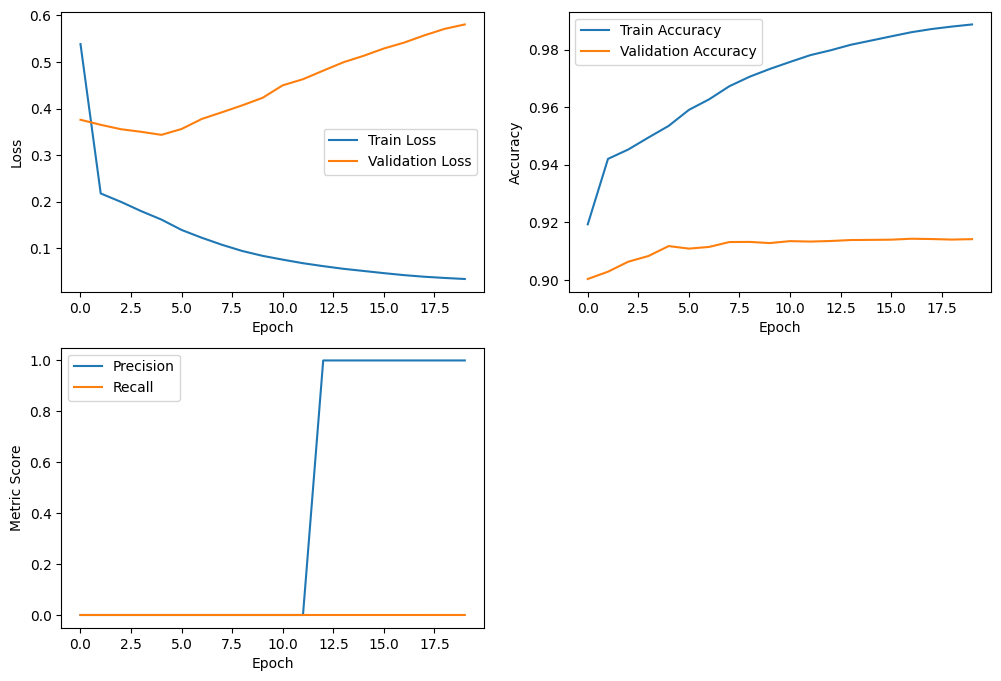

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


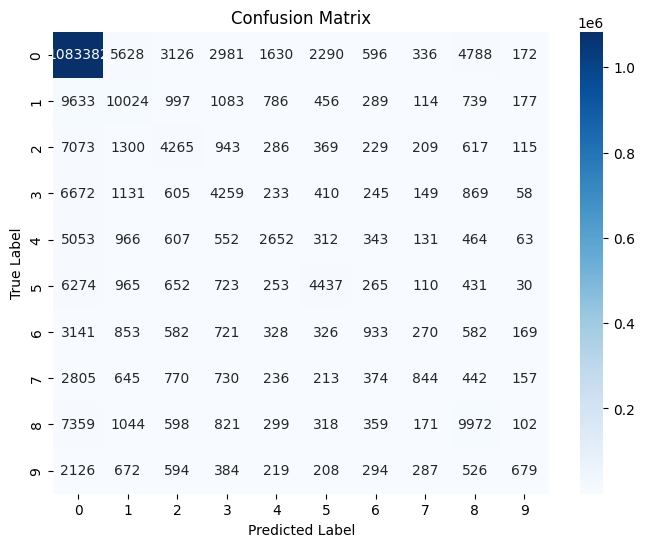

In [2]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Custom F1 Loss Function
def custom_f1_loss(y_true, y_pred):
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred * (1 - y_true))
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

# Load JSON files
def load_data(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

# Preprocess grids to one-hot encode each cell's value
def preprocess_grid(grid, max_size=30, num_classes=10):
    padded_grid = np.zeros((max_size, max_size), dtype=int)
    for i, row in enumerate(grid[:max_size]):
        padded_grid[i, :len(row[:max_size])] = row[:max_size]
    flattened_grid = padded_grid.flatten()
    return tf.keras.utils.to_categorical(flattened_grid, num_classes=num_classes)

# Prepare training and evaluation datasets
def prepare_dataset(data, solutions, max_size=30, num_classes=10):
    X, y = [], []
    for task_id, task in data.items():
        solution_train = solutions.get(task_id, [])
        for i, pair in enumerate(task.get('train', [])):
            X.append(preprocess_grid(pair.get('input', []), max_size, num_classes))
            if i < len(solution_train) and 'output' in solution_train[i]:
                y.append(preprocess_grid(solution_train[i]['output'], max_size, num_classes))
            else:
                y.append(preprocess_grid(pair.get('input', []), max_size, num_classes))
    return np.array(X), np.array(y)

# Load dataset files
train_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')
train_solutions = load_data('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json')
eval_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json')
eval_solutions = load_data('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json')
test_data = load_data('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json')

# Prepare datasets
X_train, y_train = prepare_dataset(train_data, train_solutions)
X_eval, y_eval = prepare_dataset(eval_data, eval_solutions)

# Model Architecture
def build_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((30, 30, 10)),  # Assuming a 30x30 grid with 10 classes
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(np.prod(output_shape), activation='softmax'),
        layers.Reshape(output_shape)
    ])
    return model

# Model Compilation
output_shape = (900, 10)
model = build_model(input_shape=(900, 10), output_shape=output_shape)
# Change metrics to strings instead of objects
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['categorical_accuracy', 'precision', 'recall'])

# ... (rest of the code)

# Model Training
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_eval, y_eval), verbose=1)

# Generate predictions for submission
def create_predictions(task_ids, shapes):
    predictions = {}
    for task_id in task_ids:
        grid_shape = shapes[task_id]
        attempt_1 = np.random.randint(0, 10, size=grid_shape).tolist()
        attempt_2 = np.random.randint(0, 10, size=grid_shape).tolist()
        predictions[task_id] = [{"attempt_1": attempt_1, "attempt_2": attempt_2}]
    return predictions

# Prediction file structure
eval_shapes = {task_id: (len(task["test"][0]["input"]), len(task["test"][0]["input"][0])) for task_id, task in eval_data.items()}
predictions = create_predictions(eval_data.keys(), eval_shapes)

# Save predictions to submission file
with open('submission.json', 'w') as f:
    json.dump(predictions, f)

# Plot training metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    # Change 'categorical_accuracy' to 'categorical_accuracy' for consistency
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    # Change to 'precision'
    plt.plot(history.history['precision'], label='Precision')
    # Change to 'recall'
    plt.plot(history.history['recall'], label='Recall')  
    plt.xlabel('Epoch')
    plt.ylabel('Metric Score')
    plt.legend()

    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1).flatten()
    y_pred = np.argmax(y_pred, axis=-1).flatten()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot metrics and confusion matrix
plot_metrics(history)
y_pred_eval = model.predict(X_eval)
plot_confusion_matrix(y_eval, y_pred_eval)